# Enhanced S&P 500 Backtesting with Machine Learning
Combines multi-stock data with ML predictions for trading signals.

In [12]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn import svm, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

## Data Loading & Feature Engineering
Load S&P 500 data and prepare ML features/labels.

In [13]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('../sp500data/SP500PriceHistory.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df


def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0


def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))

    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    return X, y, df

In [14]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    clf = VotingClassifier([('lsvc', svm.LinearSVC(C=0.5)),
                            ('knn', neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')),
                            ('rfor', RandomForestClassifier(n_estimators=250, max_depth=10, random_state=42))])
    

    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('accuracy:', confidence)
    predictions = clf.predict(X_test)
    print('predicted class counts:', Counter(predictions))
    print()
    print()
    return confidence

do_ml('NVDA')

Data spread: Counter({'1': 971, '-1': 765, '0': 39})
accuracy: 0.4864864864864865
predicted class counts: Counter({1: 405, -1: 39})




0.4864864864864865

## Backtrader Strategy Implementation
ML-driven trading strategy with risk management.

In [15]:
class MLStrategy(bt.Strategy):
    params = (
        ('position_size', 0.03),  # 3% risk per trade
        ('hard_stop', 0.05),      # 5% stop loss
        ('take_profit', 0.08),    # 8% take profit
        ('max_drawdown', 0.15),   # 15% portfolio drawdown limit
        ('daily_trades', 1),      # Max 1 trade per day
    )

    def __init__(self):
        # Initialize model and data references
        self.ml_model = clf
        self.data_close = self.datas[0].close
        self.peak_equity = self.broker.getvalue()
        self.current_position = None
        self.last_trade_date = None
        self.order = None
        
        # Feature configuration
        self.feature_names = [
            'Returns', 'Ret_1d', 'Ret_2d', 'Ret_3d', 'Ret_4d',
            'Ret_5d', 'Ret_6d', 'Ret_7d', 'Ret_8d', 'Ret_9d',
            'Ret_10d', 'Ret_11d', 'Ret_12d', 'Ret_13d', 'Ret_14d'
        ]
        
        # Drawdown tracking
        self.drawdown_alert = False
        self.equity = []

    def next(self):
        # Prevent trading during drawdown alert or existing orders
        if self.drawdown_alert or self.order:
            return
            
        # Check daily trade limit using current bar's date
        current_date = self.data.datetime.date(0)
        if current_date == self.last_trade_date:
            return

        # Calculate current drawdown
        current_equity = self.broker.getvalue()
        self.peak_equity = max(self.peak_equity, current_equity)
        drawdown = (self.peak_equity - current_equity) / self.peak_equity
        
        # Global circuit breaker
        if drawdown >= self.params.max_drawdown:
            self.drawdown_alert = True
            self.close()
            print(f"Drawdown limit reached: {drawdown:.2%}")
            return

        try:
            # Generate validated features
            current_features = [
                self.data_close[0]/self.data_close[-1] - 1,
                self.data_close[-1]/self.data_close[-2] - 1,
                self.data_close[-2]/self.data_close[-3] - 1,
                self.data_close[-3]/self.data_close[-4] - 1,
                self.data_close[-4]/self.data_close[-5] - 1,
                self.data_close[-5]/self.data_close[-6] - 1,
                self.data_close[-6]/self.data_close[-7] - 1,
                self.data_close[-7]/self.data_close[-8] - 1,
                self.data_close[-8]/self.data_close[-9] - 1,
                self.data_close[-9]/self.data_close[-10] - 1,
                self.data_close[-10]/self.data_close[-11] - 1,
                self.data_close[-11]/self.data_close[-12] - 1,
                self.data_close[-12]/self.data_close[-13] - 1,
                self.data_close[-13]/self.data_close[-14] - 1,
                self.data_close[-14]/self.data_close[-15] - 1,
            ]
            
            # Convert to DataFrame
            df_features = pd.DataFrame([current_features], columns=self.feature_names)
            
            # Get prediction
            prediction = self.ml_model.predict(df_features)[0]
            
        except (IndexError, ValueError) as e:
            print(f"Skipping trade: {str(e)}")
            return

        # Close existing position if signal changes
        if prediction != self.current_position:
            self.close()
            self.current_position = None

        # Calculate position size with current equity
        position_value = self.broker.getvalue() * self.params.position_size
        size = position_value / self.data_close[0]

        # Execute new trade with corrected date validation
        if not self.position and prediction != 0:
            if prediction == 1:
                self.order = self.buy(
                    size=size,
                    exectype=bt.Order.Close,
                    valid=self.data.datetime.date(0)  # Current date only
                )
                # Add stop loss
                self.sell(
                    exectype=bt.Order.StopTrail, 
                    trailamount=self.params.hard_stop * self.data_close[0],
                    trailpercent=self.params.hard_stop
                )
                
            elif prediction == -1:
                self.order = self.sell(
                    size=size,
                    exectype=bt.Order.Close,
                    valid=self.data.datetime.date(0)  # Current date only
                )
                # Add stop loss
                self.buy(
                    exectype=bt.Order.StopTrail,
                    trailamount=self.params.hard_stop * self.data_close[0],
                    trailpercent=self.params.hard_stop
                )
            
            self.last_trade_date = current_date
            self.current_position = prediction

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            self.order = None

    def notify_trade(self, trade):
        # Update equity curve
        self.equity.append(self.broker.getvalue())

## Backtesting Execution
Run the backtest with performance analysis.

In [16]:
class BacktestEngine:
    def __init__(self, data):
        self.cerebro = bt.Cerebro()
        self.cerebro.addstrategy(MLStrategy)
        self.cerebro.broker.setcash(100000.0)
        self.cerebro.broker.setcommission(0.001)
        
        # Configure data feed with column names from the new DataFrame
        datafeed = bt.feeds.PandasData(
            dataname=data,
            open='Open',
            high='High',
            low='Low',
            close='Close',
            volume='Volume',
            openinterest=None
        )
        self.cerebro.adddata(datafeed)
        
        # Add analyzers (unchanged)
        self.cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                               _name='sharpe', 
                               timeframe=bt.TimeFrame.Days)
        self.cerebro.addanalyzer(bt.analyzers.DrawDown, 
                               _name='drawdown')

    def run(self):
        print("Starting Portfolio Value: %.2f" % self.cerebro.broker.getvalue())
        self.results = self.cerebro.run()
        print("Final Portfolio Value: %.2f" % self.cerebro.broker.getvalue())
        return self.results[0]

    def analyze(self):
        strat = self.results[0]
        print("\nPerformance Analysis:")
        
        sharpe = strat.analyzers.sharpe.get_analysis()
        drawdown = strat.analyzers.drawdown.get_analysis()
        
        print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
        print(f"Max Drawdown: {drawdown['max']['drawdown']:.2%}")
        
        # Plot with Jupyter-safe settings
        self.cerebro.plot(style='candlestick', iplot=False, volume=False)


In [17]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['backend'] = 'module://matplotlib_inline.backend_inline'

Cleaned 5-Minute Data Summary:
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
Date Range: 2024-02-21 09:00:00 to 2025-01-18 00:55:00
Total Data Points: 43515

Sample Data:
                       Open    High     Low   Close  Volume
time                                                       
2024-02-21 09:00:00  68.131  68.328  67.879  68.301  177780
2024-02-21 09:05:00  68.275  68.534  68.225  68.495  233750
2024-02-21 09:10:00  68.450  68.580  68.300  68.411  296190
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99964.31

Performance Analysis:
Sharpe Ratio: -3.19
Max Drawdown: 4.53%


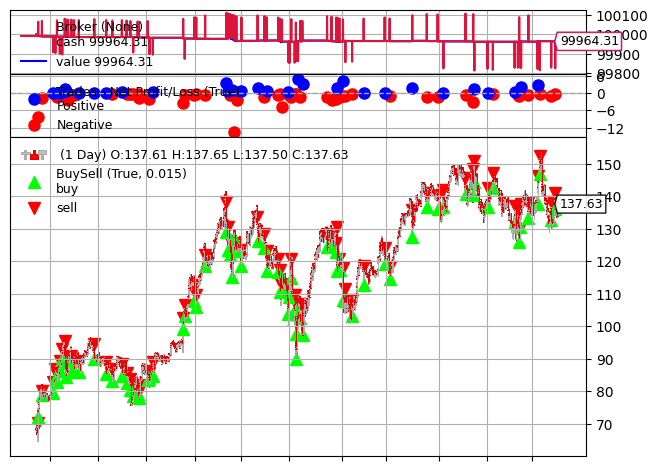

In [18]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config
import pandas as pd
import setup

ticker = "NVDA"  
days = 720 

queryset = market_services.get_5min_stock_quotes_queryset(ticker, days=days)

df = pd.DataFrame.from_records(list(queryset.values()))
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df = df.rename(columns={
    'open_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'close_price': 'Close',
    'volume': 'Volume'
})


df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)
df.index = df.index.tz_localize(None)  
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

print("Cleaned 5-Minute Data Summary:")
print(f"Columns: {df.columns.tolist()}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Total Data Points: {len(df)}")
print(f"\nSample Data:\n{df.head(3)}")

engine = BacktestEngine(df)
final_value = engine.run()
engine.analyze()

## Parameter Optimization
Optimize ML model parameters and position sizing.

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rfc__n_estimators': [50, 100, 200],
    'knn__n_neighbors': [3, 5, 7],
    'lsvc__C': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Optimized Accuracy:", grid_search.best_score_)


Best Parameters: {'knn__n_neighbors': 3, 'lsvc__C': 0.5, 'rfc__n_estimators': 200}
Optimized Accuracy: 0.515909090909091
